<!-- <p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p> -->
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>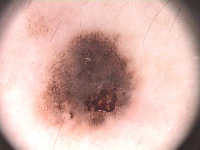</td><td>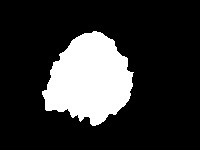</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
# !wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# https://www.kaggle.com/datasets/kanametov/ph2dataset

In [2]:
!ls

In [3]:
# !apt-get install unrar
# get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/kaggle/input/ph2dataset/PH2Dataset'
# root = 'PH2Dataset'

# for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

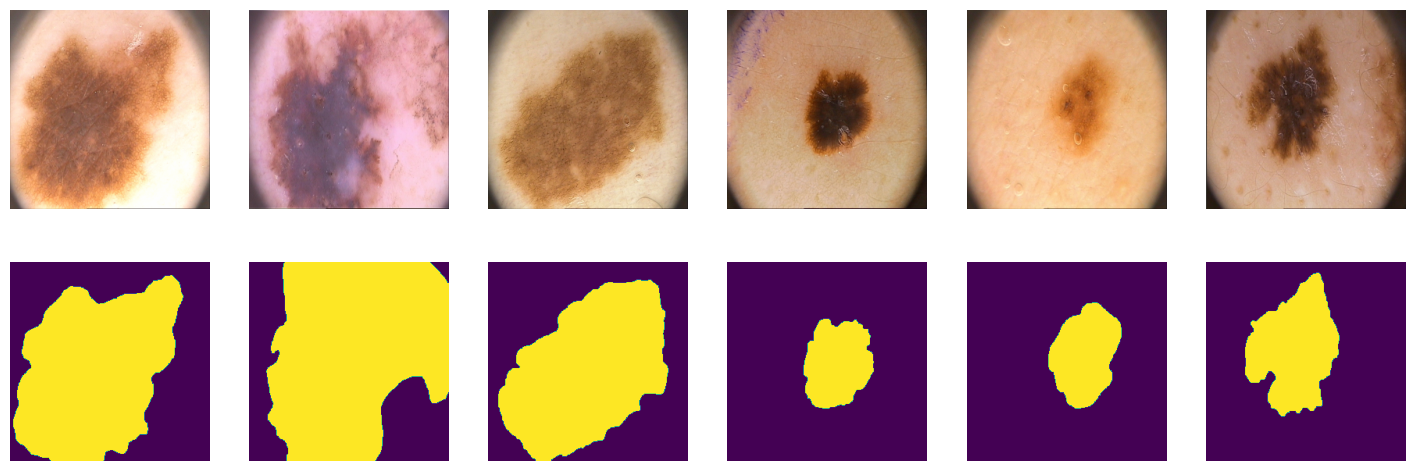

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

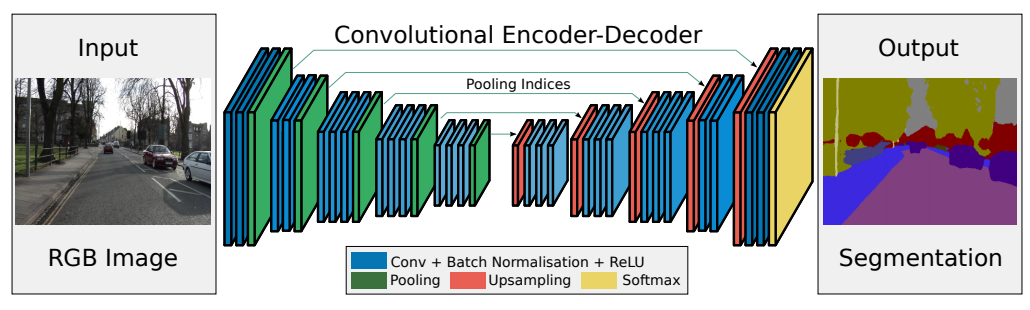

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import numpy as np

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [14]:
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):

        super().__init__()

        self.conv_bn_relu = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_bn_relu(x)

In [15]:
class SegNet(nn.Module):
    def __init__(self, out_channels=1):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            ConvBNRelu(3, 64),
            ConvBNRelu(64, 64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            ConvBNRelu(64, 128),
            ConvBNRelu(128, 128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            ConvBNRelu(128, 256),
            ConvBNRelu(256, 256),
            ConvBNRelu(256, 256)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            ConvBNRelu(256, 512),
            ConvBNRelu(512, 512),
            ConvBNRelu(512, 512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            ConvBNRelu(512, 512),
            ConvBNRelu(512, 512),
            ConvBNRelu(512, 512)
        )

        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleneck_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.bottleneck_dec_conv = nn.Sequential(
            ConvBNRelu(512, 512),
            ConvBNRelu(512, 512),
            ConvBNRelu(512, 512)
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            ConvBNRelu(512, 256),
            ConvBNRelu(256, 256),
            ConvBNRelu(256, 256)
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            ConvBNRelu(256, 128),
            ConvBNRelu(128, 128),
            ConvBNRelu(128, 128)
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            ConvBNRelu(128, 64),
            ConvBNRelu(64, 64)
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            ConvBNRelu(64, 64),
            nn.Conv2d(
                    in_channels=64,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1
            )
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        eb, ind_b = self.bottleneck_pool(self.bottleneck_conv(e3))
        db = self.bottleneck_dec_conv(self.bottleneck_unpool(eb, ind_b))

        # decoder
        d0 = self.dec_conv0(self.upsample0(db, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0)) # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    
    SMOOTH = 1e-8
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [17]:
def bce_loss(y_pred, y_real):
    loss = (torch.clip(y_pred, 0) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))).mean()
    return loss

In [18]:
y_real = torch.empty(100).random_(2)
y_pred_logit = (torch.Tensor(np.random.sample(100)) - 0.5) * 10

nn.BCEWithLogitsLoss()(y_pred_logit, y_real), bce_loss(y_pred_logit, y_real)

(tensor(1.4410), tensor(1.4410))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [19]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):

    tic = time()
    X_val, Y_val = next(iter(data_val))
    history = []
    best_train_score = 0
    best_val_score = 0

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        running_loss = 0
        processed_data = 0
        avg_loss = 0
        
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()

            # calculate loss to show the user
            running_loss += loss.item() * X_batch.size(0)
            processed_data += X_batch.size(0)
        
        avg_loss = running_loss / processed_data
        print('train loss: %f' % avg_loss)
        
        current_score = score_model(model, iou_pytorch, data_tr)
        print(f'current train score {current_score}')
        best_train_score = max(best_train_score, current_score)

        # show intermediate results

        running_loss_val = 0
        processed_data_val = 0
        avg_loss_val = 0

        model.eval()  # testing mode
        with torch.no_grad():
            for X_val, Y_val in data_val:
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                Y_hat = model(X_val)
                loss_val = loss_fn(Y_hat, Y_val)
                
                running_loss_val += loss_val.item() * X_val.size(0)
                processed_data_val += X_val.size(0)
                
        avg_loss_val += running_loss_val / processed_data_val
        current_score_val = score_model(model, iou_pytorch, data_val)

        best_val_score = max(best_val_score, current_score_val)
        history.append((avg_loss, current_score, avg_loss_val, current_score_val))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0].cpu(), cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

        time_elapsed = time() - tic
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best train score: {:4f}'.format(best_train_score))
        print('Best val score: {:4f}'.format(best_val_score))
    return history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [20]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        Y_pred = model(X_batch)
        Y_pred = torch.where(Y_pred >= 0.5, 1, 0)
        scores += metric(Y_pred, Y_label).mean().item()

    return scores / len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [21]:
model = SegNet().to(device)

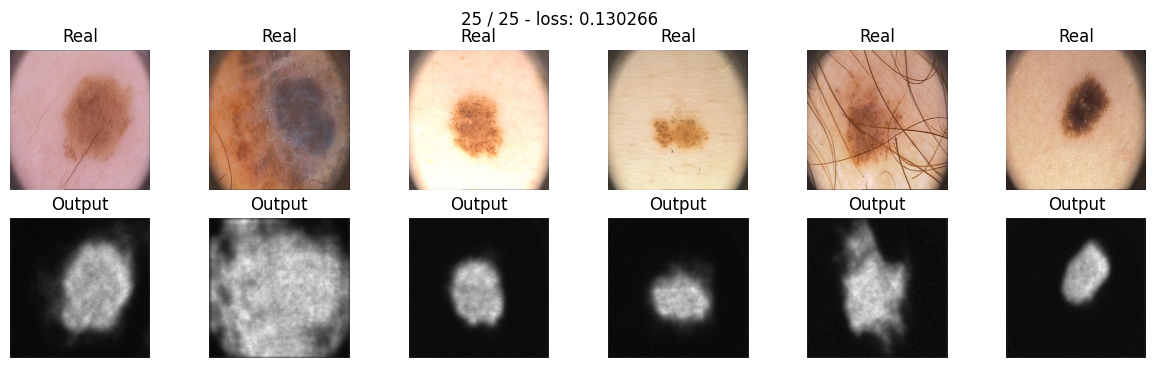

Training complete in 1m 43s
Best train score: 0.855000
Best val score: 0.744000


In [22]:
max_epochs = 25
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
history = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [23]:
score_train_segnet_bce = score_model(model, iou_pytorch, data_tr)
score_val_segnet_bce = score_model(model, iou_pytorch, data_val)
score_test_segnet_bce = score_model(model, iou_pytorch, data_ts)

print(f'train score = {score_train_segnet_bce:.4f}\nval score = {score_val_segnet_bce:.4f}\ntest score = {score_test_segnet_bce:.4f}')

train score = 0.8390
val score = 0.7140
test score = 0.7320


In [24]:
def plot_history(param, history):
    train_loss, train_acc, val_loss, val_acc = zip(*history)
    
    history_map = {
        "accuracy": (train_acc, val_acc),
        "loss": (train_loss, val_loss)
    }
    
    plt.figure(figsize=(8, 6))
    plt.plot(history_map[param][0], label='train')
    plt.plot(history_map[param][1], label='val')
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel(param)
    plt.title(f"{param} history")
    plt.grid()
    plt.show()

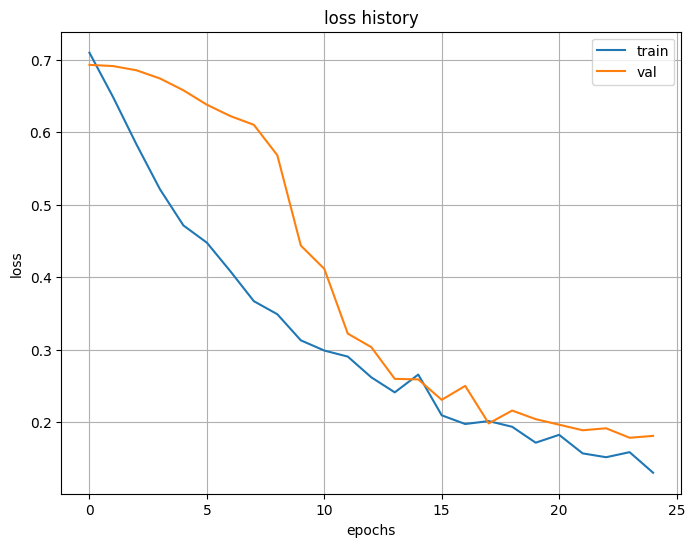

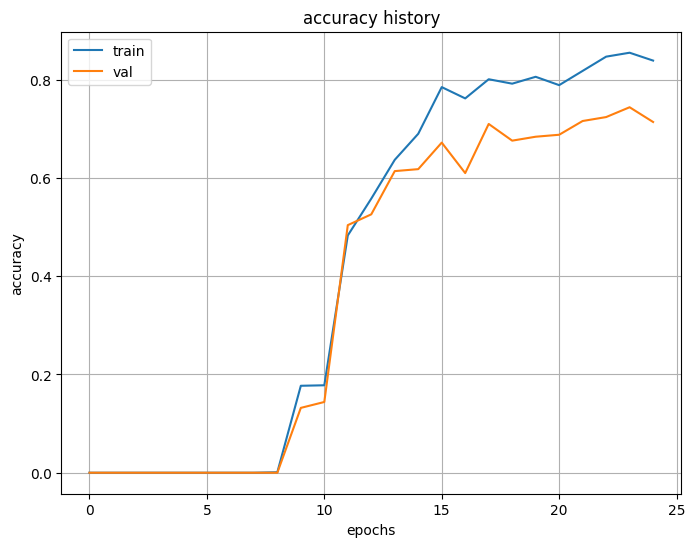

In [25]:
plot_history("loss", history)
plot_history("accuracy", history)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [26]:
def dice_loss(y_pred, y_real, eps=1e-8):
    y_pred = torch.sigmoid(y_pred)
    num = torch.sum(2 * y_real * y_pred)
    den = torch.sum(y_real + y_pred)

    res = 1 - ((num + eps) / (den + eps))
    return res

Проводим тестирование:

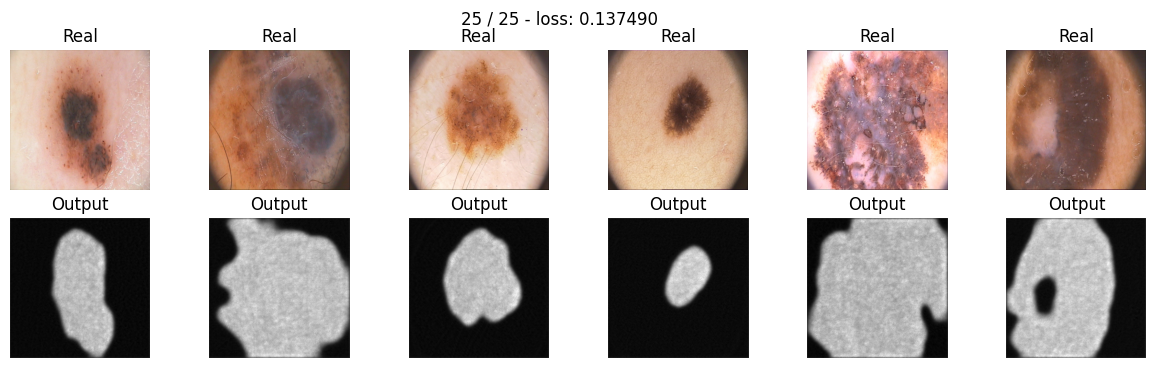

Training complete in 1m 41s
Best train score: 0.831000
Best val score: 0.704000


In [27]:
model_dice = SegNet().to(device)

max_epochs = 25
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
history_dice_loss = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [28]:
score_train_segnet_dice = score_model(model_dice, iou_pytorch, data_tr)
score_val_segnet_dice = score_model(model_dice, iou_pytorch, data_val)
score_test_segnet_dice= score_model(model_dice, iou_pytorch, data_ts)

print(f'train score = {score_train_segnet_dice:.4f}\nval score = {score_val_segnet_dice:.4f}\ntest score = {score_test_segnet_dice:.4f}')

train score = 0.8310
val score = 0.7040
test score = 0.7300


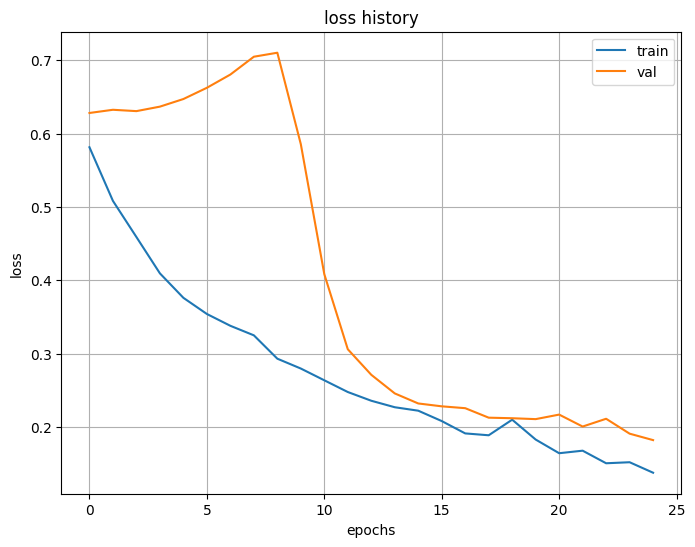

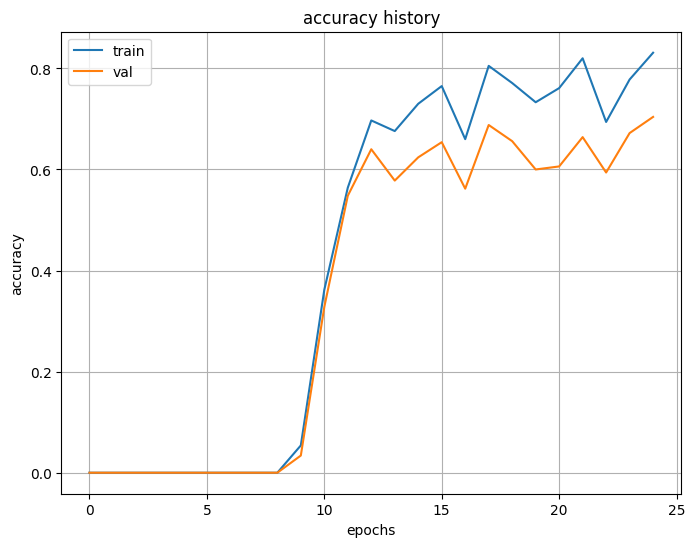

In [29]:
plot_history("loss", history_dice_loss)
plot_history("accuracy", history_dice_loss)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [30]:
torch.cuda.empty_cache()

In [31]:
def focal_loss(y_pred, y_real, eps=1e-8, gamma=2):    
    y_pred = torch.clamp(y_pred, min=eps)
    bce_loss = nn.BCEWithLogitsLoss()(y_pred, y_real)
    pt = torch.exp(-bce_loss)
    loss = (1- pt) ** gamma * bce_loss
    return loss.mean()

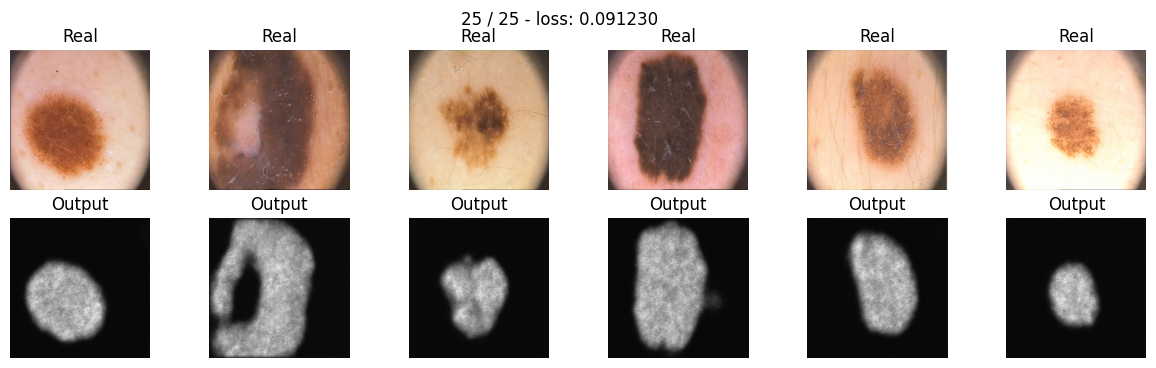

Training complete in 1m 42s
Best train score: 0.801000
Best val score: 0.718000


In [32]:
model_focal = SegNet().to(device)

max_epochs = 25
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
history_focal_loss = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [33]:
score_train_segnet_focal = score_model(model_focal, iou_pytorch, data_tr)
score_val_segnet_focal = score_model(model_focal, iou_pytorch, data_val)
score_test_segnet_focal= score_model(model_focal, iou_pytorch, data_ts)

print(f'train score = {score_train_segnet_focal:.4f}\nval score = {score_val_segnet_focal:.4f}\ntest score = {score_test_segnet_focal:.4f}')

train score = 0.8010
val score = 0.7180
test score = 0.7180


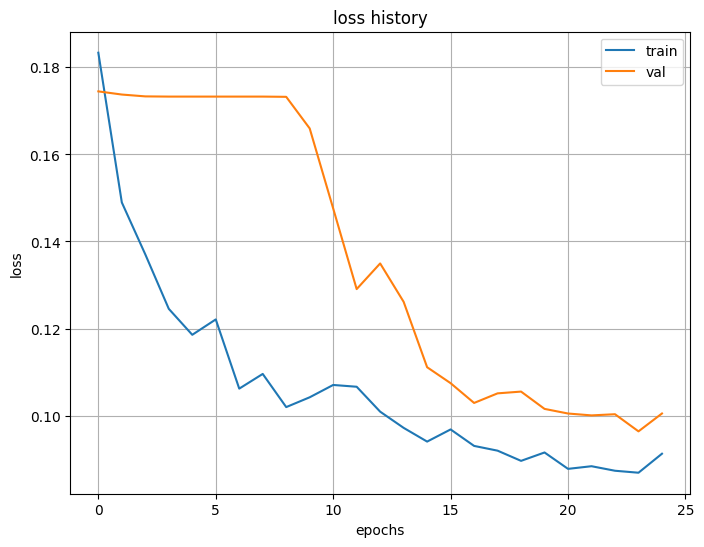

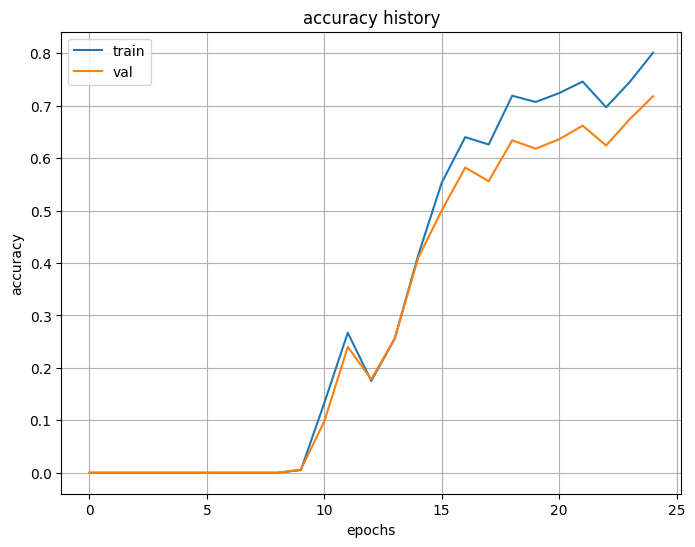

In [34]:
plot_history("loss", history_focal_loss)
plot_history("accuracy", history_focal_loss)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [35]:
def bce_loss_smooth(y_pred, y_real, alpha=0.1, num_classes=2):
    y_real = torch.clamp(y_real, alpha / num_classes, 1 - alpha / num_classes)
    loss = nn.BCEWithLogitsLoss()(y_pred, y_real)
    return loss

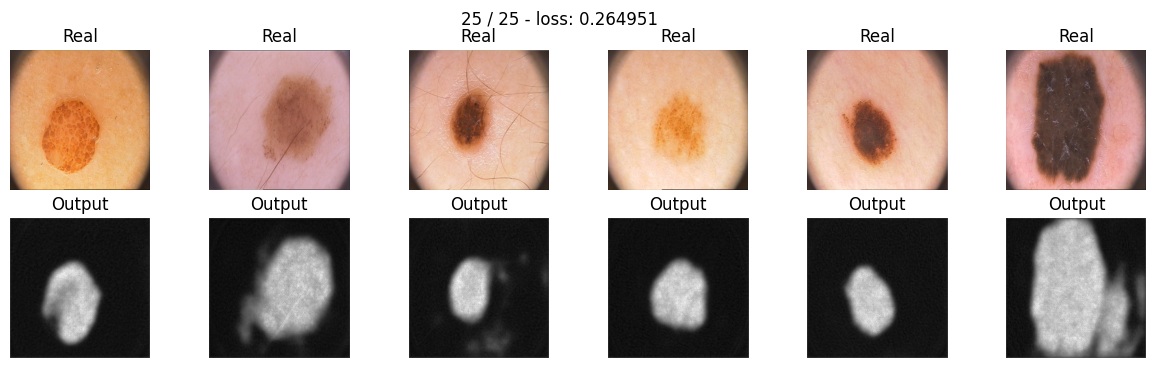

Training complete in 1m 42s
Best train score: 0.898000
Best val score: 0.720000


In [36]:
model_bce_smooth = SegNet().to(device)

max_epochs = 25
optimaizer = torch.optim.Adam(model_bce_smooth.parameters(), lr=1e-4)
history_bce_smooth_loss = train(model_bce_smooth, optimaizer, bce_loss_smooth, max_epochs, data_tr, data_val)

In [37]:
score_train_segnet_bce_smooth = score_model(model_bce_smooth, iou_pytorch, data_tr)
score_val_segnet_bce_smooth = score_model(model_bce_smooth, iou_pytorch, data_val)
score_test_segnet_bce_smooth= score_model(model_bce_smooth, iou_pytorch, data_ts)

print(f'train score = {score_train_segnet_bce_smooth:.4f}\nval score = {score_val_segnet_bce_smooth:.4f}\ntest score = {score_test_segnet_bce_smooth:.4f}')

train score = 0.8490
val score = 0.6540
test score = 0.6800


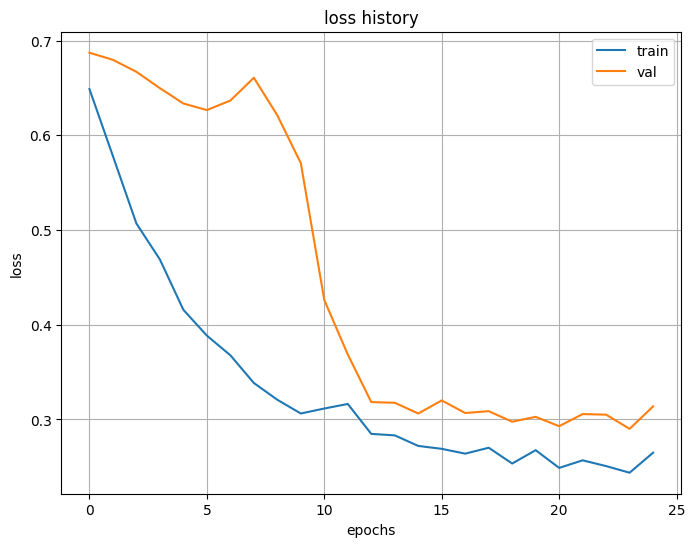

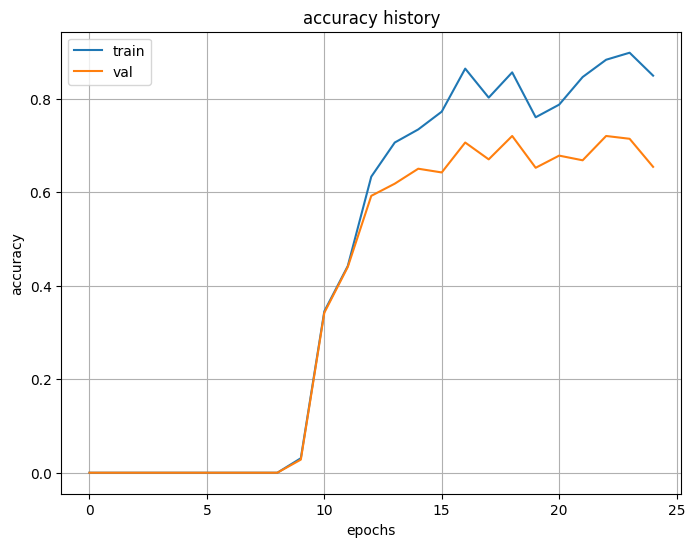

In [38]:
plot_history("loss", history_bce_smooth_loss)
plot_history("accuracy", history_bce_smooth_loss)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

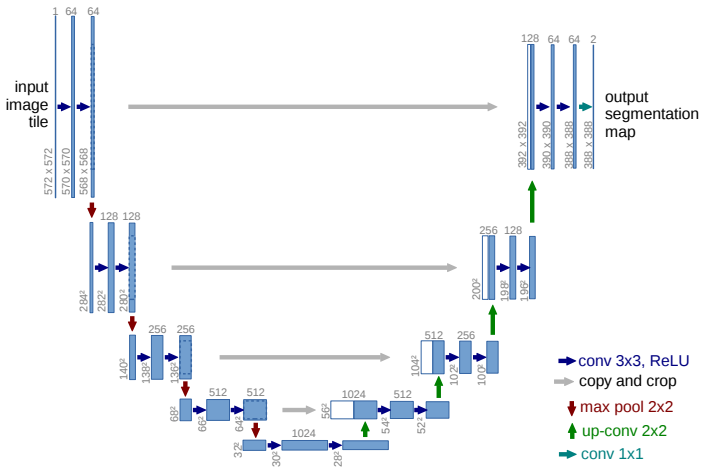

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [39]:
class UNet(nn.Module):
    def __init__(self, out_channels=1):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        
        self.enc_conv0 = nn.Sequential(
            ConvBNRelu(3, 64),
            ConvBNRelu(64, 64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            ConvBNRelu(64, 128),
            ConvBNRelu(128, 128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            ConvBNRelu(128, 256),
            ConvBNRelu(256, 256)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            ConvBNRelu(256, 512),
            ConvBNRelu(512, 512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            ConvBNRelu(512, 1024),
            ConvBNRelu(1024, 1024)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='nearest') # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            ConvBNRelu(1024, 512),
            ConvBNRelu(512, 512)
        )
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest') # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            ConvBNRelu(512, 256),
            ConvBNRelu(256, 256)
        )
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest') # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            ConvBNRelu(256, 128),
            ConvBNRelu(128, 128)
        )
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest') # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            ConvBNRelu(128, 64),
            ConvBNRelu(64, 64),
            nn.Conv2d(
                    in_channels=64,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=1
            )
        )

    def forward(self, x):
        # encoder
        e00 = self.enc_conv0(x)
        e01 = self.pool0(e00)
        
        e10 = self.enc_conv1(e01)
        e11 = self.pool1(e10)
        
        e20 = self.enc_conv2(e11)
        e21 = self.pool2(e20)
        
        e30 = self.enc_conv3(e21)
        e31 = self.pool3(e30)
        

        # bottleneck
        b = self.bottleneck_conv(e31)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e30), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e20), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e10), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e00), dim=1))  # no activation
        return d3

In [40]:
unet_model = UNet().to(device)

In [41]:
max_epochs = 25
optimaizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)

unet_history = train(unet_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

* Epoch 1/25


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 30 but got size 31 for tensor number 1 in the list.

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [42]:
class UNet2(nn.Module):
    def __init__(self, out_channels=1):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        
        self.enc_conv0 = nn.Sequential(
            ConvBNRelu(3, 64),
            ConvBNRelu(64, 64)
        )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            ConvBNRelu(64, 128),
            ConvBNRelu(128, 128)
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            ConvBNRelu(128, 256),
            ConvBNRelu(256, 256)
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            ConvBNRelu(256, 512),
            ConvBNRelu(512, 512)
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            ConvBNRelu(512, 1024),
            ConvBNRelu(1024, 1024)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            ConvBNRelu(1024, 512),
            ConvBNRelu(512, 512)
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            ConvBNRelu(512, 256),
            ConvBNRelu(256, 256)
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            ConvBNRelu(256, 128),
            ConvBNRelu(128, 128)
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            ConvBNRelu(128, 64),
            ConvBNRelu(64, 64),
            nn.Conv2d(
                    in_channels=64,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1
            )
        )

    def forward(self, x):
        # encoder
        e00 = self.enc_conv0(x)
        e01 = self.pool0(e00)
        
        e10 = self.enc_conv1(e01)
        e11 = self.pool1(e10)
        
        e20 = self.enc_conv2(e11)
        e21 = self.pool2(e20)
        
        e30 = self.enc_conv3(e21)
        e31 = self.pool3(e30)
        

        # bottleneck
        b = self.bottleneck_conv(e31)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e30), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e20), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e10), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e00), dim=1))  # no activation
        return d3

In [43]:
unet2_model = UNet2().to(device)

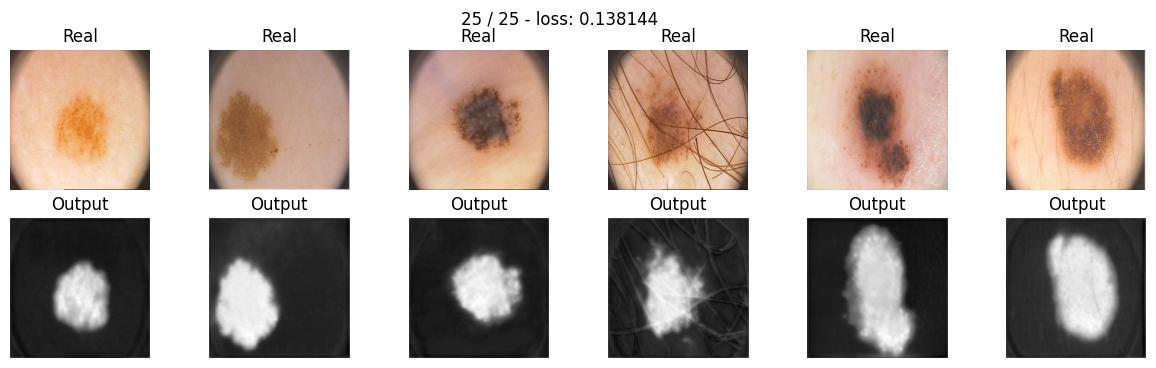

Training complete in 2m 20s
Best train score: 0.846000
Best val score: 0.748000


In [44]:
max_epochs = 25
optimaizer = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)

unet2_history = train(unet2_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [45]:
score_train_unet_bce = score_model(unet2_model, iou_pytorch, data_tr)
score_val_unet_bce = score_model(unet2_model, iou_pytorch, data_val)
score_test_unet_bce= score_model(unet2_model, iou_pytorch, data_ts)

print(f'train score = {score_train_unet_bce:.4f}\nval score = {score_val_unet_bce:.4f}\ntest score = {score_test_unet_bce:.4f}')

train score = 0.8460
val score = 0.7480
test score = 0.7660


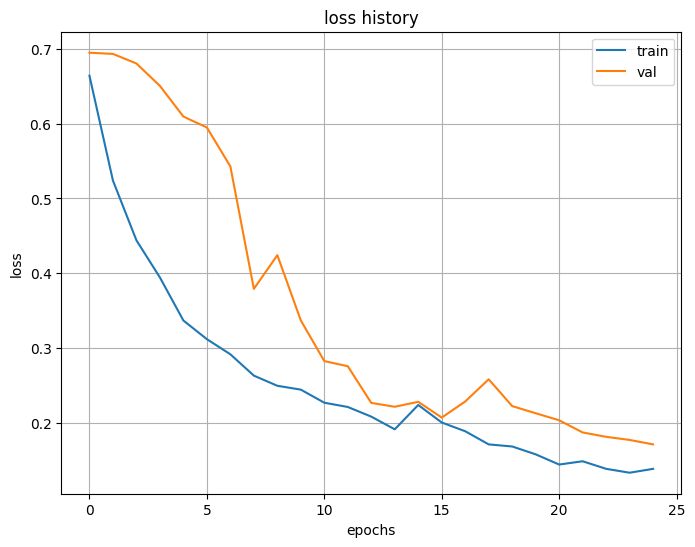

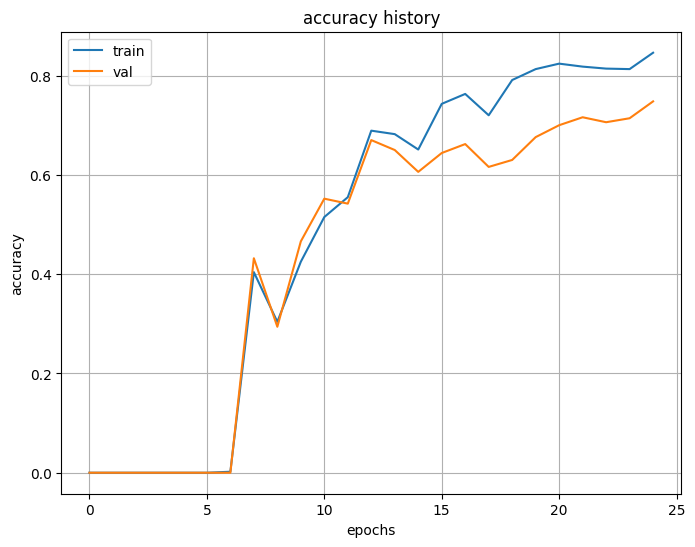

In [46]:
plot_history("loss", unet2_history)
plot_history("accuracy", unet2_history)

### dice loss

In [47]:
unet2_model = UNet2().to(device)

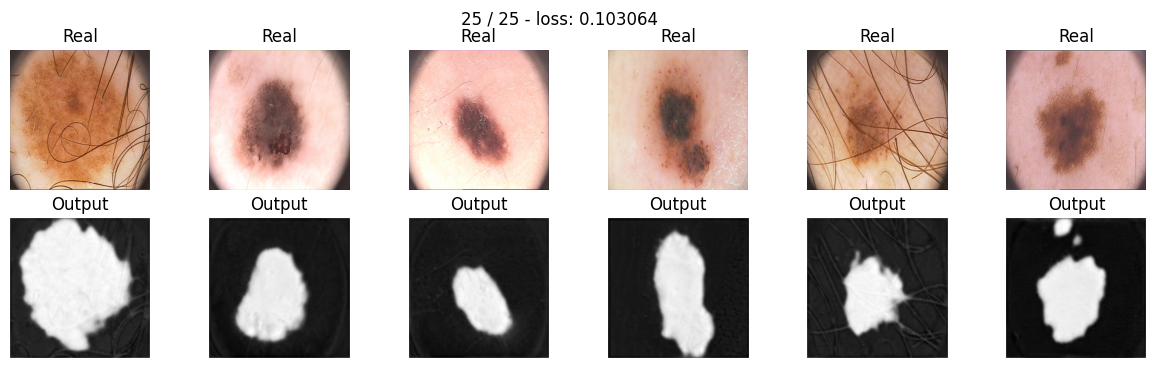

Training complete in 2m 19s
Best train score: 0.850000
Best val score: 0.726000


In [48]:
max_epochs = 25
optimaizer = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)

unet2_history_dice = train(unet2_model, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [49]:
score_train_unet_dice = score_model(unet2_model, iou_pytorch, data_tr)
score_val_unet_dice = score_model(unet2_model, iou_pytorch, data_val)
score_test_unet_dice = score_model(unet2_model, iou_pytorch, data_ts)

print(f'train score = {score_train_unet_dice:.4f}\nval score = {score_val_unet_dice:.4f}\ntest score = {score_test_unet_dice:.4f}')

train score = 0.8410
val score = 0.7180
test score = 0.7640


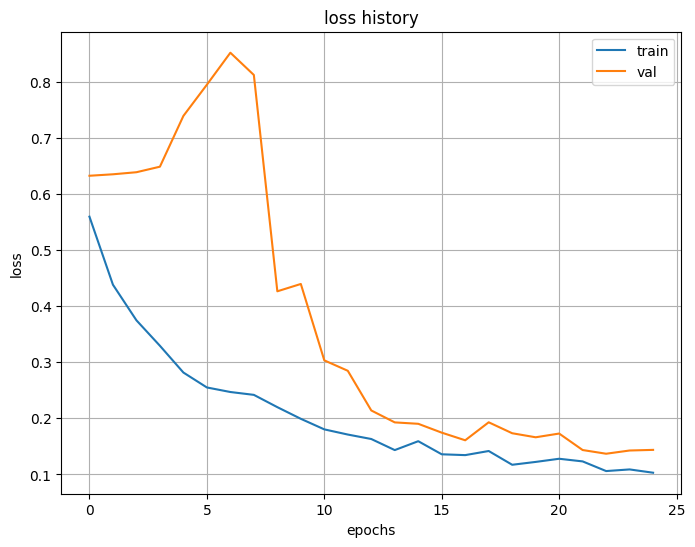

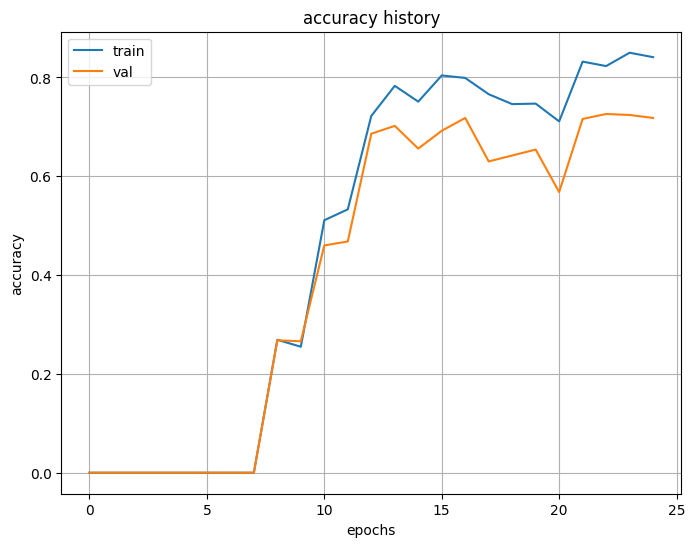

In [50]:
plot_history("loss", unet2_history_dice)
plot_history("accuracy", unet2_history_dice)

### focal loss

In [57]:
unet2_model = UNet2().to(device)

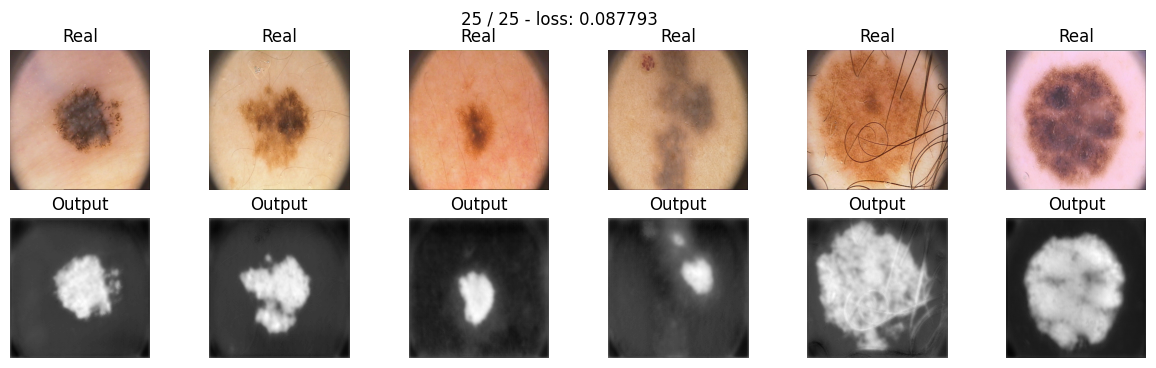

Training complete in 2m 20s
Best train score: 0.809000
Best val score: 0.718000


In [59]:
max_epochs = 25
optimaizer = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)

unet2_history_focal = train(unet2_model, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [60]:
score_train_unet_focal = score_model(unet2_model, iou_pytorch, data_tr)
score_val_unet_focal = score_model(unet2_model, iou_pytorch, data_val)
score_test_unet_focal = score_model(unet2_model, iou_pytorch, data_ts)

print(f'train score = {score_train_unet_focal:.4f}\nval score = {score_val_unet_focal:.4f}\ntest score = {score_test_unet_focal:.4f}')

train score = 0.7930
val score = 0.6980
test score = 0.6880


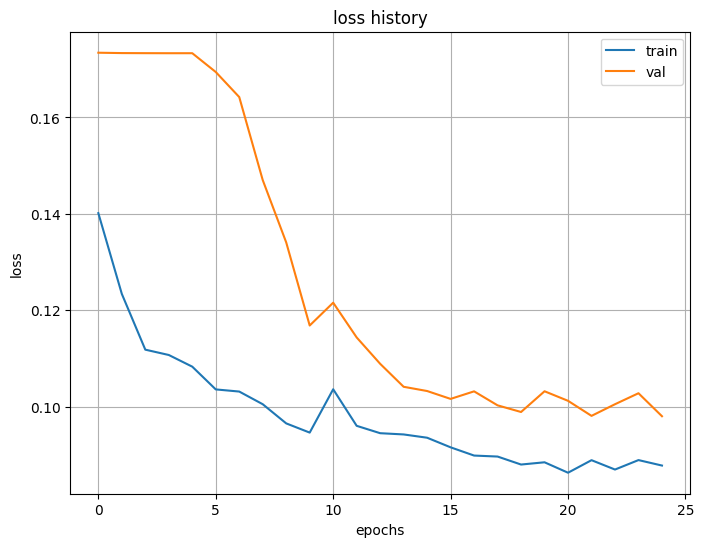

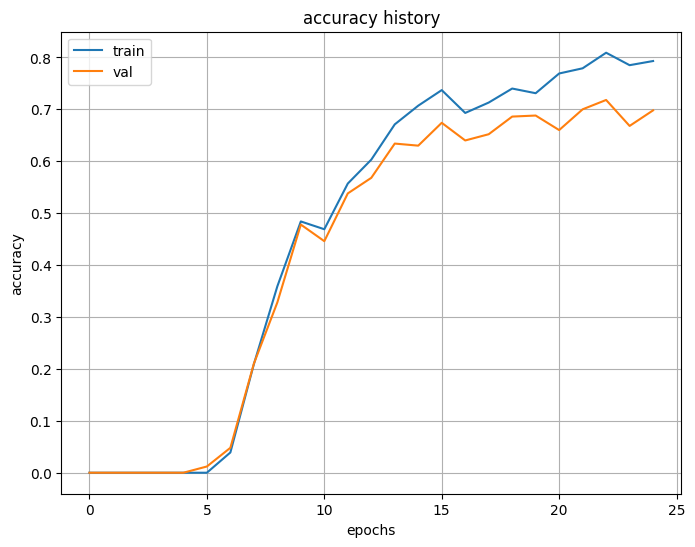

In [61]:
plot_history("loss", unet2_history_focal)
plot_history("accuracy", unet2_history_focal)

### bce smooth loss

In [62]:
unet2_model = UNet2().to(device)

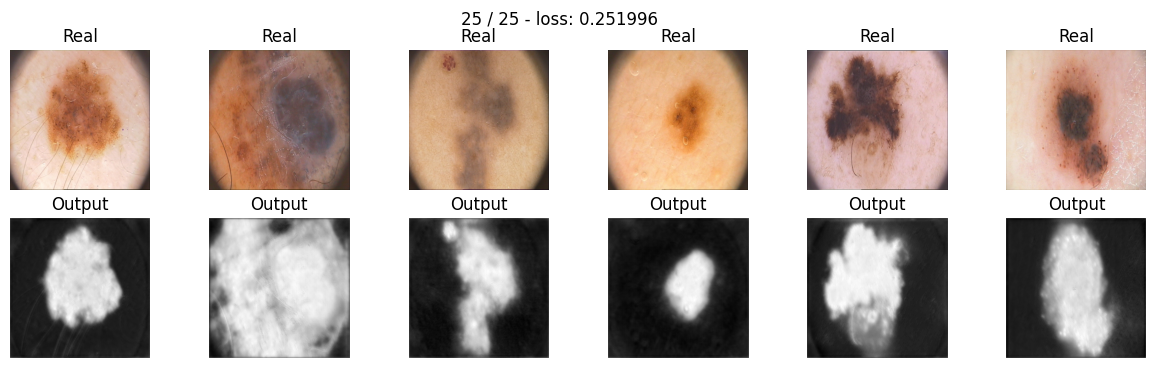

Training complete in 2m 20s
Best train score: 0.854000
Best val score: 0.748000


In [63]:
max_epochs = 25
optimaizer = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)

unet2_history_bce_smooth = train(unet2_model, optimaizer, bce_loss_smooth, max_epochs, data_tr, data_val)

In [64]:
score_train_unet_bce_smooth = score_model(unet2_model, iou_pytorch, data_tr)
score_val_unet_bce_smooth = score_model(unet2_model, iou_pytorch, data_val)
score_test_unet_bce_smooth = score_model(unet2_model, iou_pytorch, data_ts)

print(f'train score = {score_train_unet_bce_smooth:.4f}\nval score = {score_val_unet_bce_smooth:.4f}\ntest score = {score_test_unet_bce_smooth:.4f}')

train score = 0.8430
val score = 0.7360
test score = 0.7480


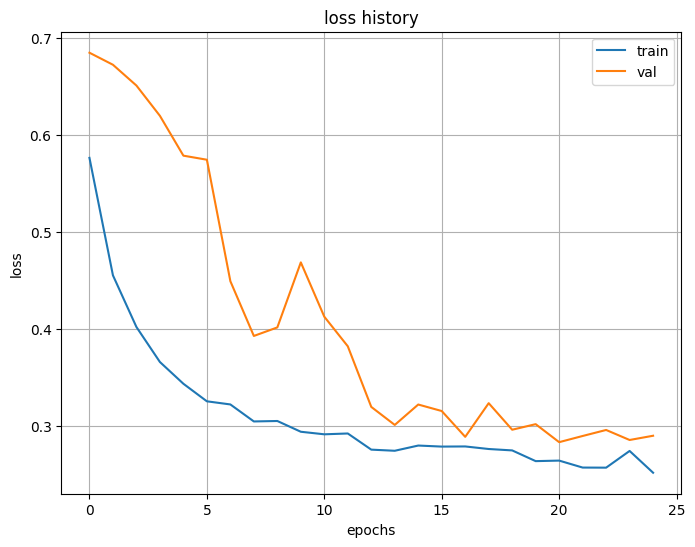

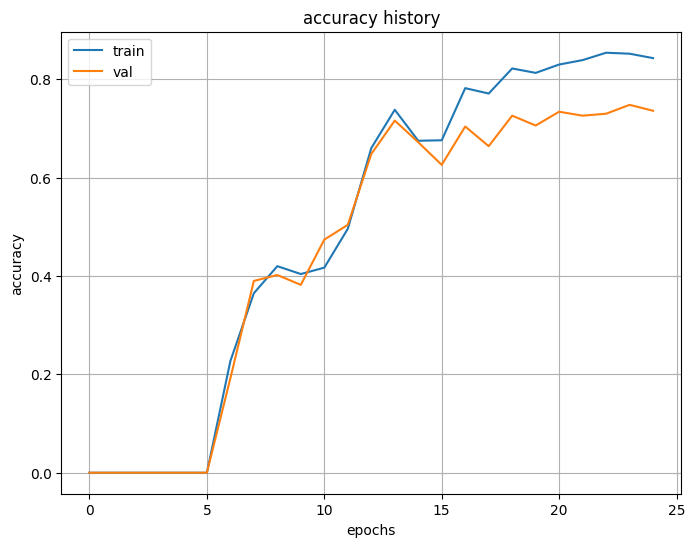

In [65]:
plot_history("loss", unet2_history_bce_smooth)
plot_history("accuracy", unet2_history_bce_smooth)

In [52]:
import pandas as pd

In [70]:
res_df = pd.DataFrame(data=[
   ('segnet', 'bce', score_train_segnet_bce, score_val_segnet_bce, score_test_segnet_bce),
   ('segnet', 'dice', score_train_segnet_dice, score_val_segnet_dice, score_test_segnet_dice),
   ('segnet', 'focal', score_train_segnet_focal, score_val_segnet_focal, score_test_segnet_focal),
   ('segnet', 'bce_smooth', score_train_segnet_bce_smooth, score_val_segnet_bce_smooth, score_test_segnet_bce_smooth),
   ('unet2', 'bce', score_train_unet_bce, score_val_unet_bce, score_val_unet_bce),
   ('unet2', 'dice', score_train_unet_dice, score_val_unet_dice, score_val_unet_dice),
   ('unet2', 'focal', score_train_unet_focal, score_val_unet_focal, score_val_unet_focal),
   ('unet2', 'bce_smooth', score_train_unet_bce_smooth, score_val_unet_bce_smooth, score_val_unet_bce_smooth),
], columns=['model', 'loss', 'train_score', 'val_score', 'test_score']).sort_values('test_score', ascending=False).reset_index(drop=True)

res_df

model        loss  train_score  val_score  test_score
0   unet2         bce        0.846      0.748       0.748
1   unet2  bce_smooth        0.843      0.736       0.736
2  segnet         bce        0.839      0.714       0.732
3  segnet        dice        0.831      0.704       0.730
4   unet2        dice        0.841      0.718       0.718
5  segnet       focal        0.801      0.718       0.718
6   unet2       focal        0.793      0.698       0.698
7  segnet  bce_smooth        0.849      0.654       0.680